In [2]:
# Attempt to get this working in spring 2025: 
# https://github.com/magenta/magenta/blob/main/magenta/models/sketch_rnn/sketch_rnn_train.py

!python --version
# We're expecting Python 3.10.12

Python 3.10.12


In [3]:
import os
import sys
import contextlib

# Suppress pip warnings and dependency conflict errors from showing in notebook
with contextlib.redirect_stdout(open(os.devnull, 'w')), contextlib.redirect_stderr(open(os.devnull, 'w')):
    !pip install --quiet tensorflow==2.13.0 numpy==1.24.3 six requests tensorflow-probability==0.12.2

# This installs:
# - TensorFlow 2.13.0 (needed for Sketch-RNN)
# - NumPy 1.24.3 (before `np.bool` breaks compatibility)
# - TensorFlow Probability 0.12.2 (clean and stable with TF 2.13)
#
# We're intentionally ignoring dependency warnings from unrelated Kaggle packages like
# `google-api-core`, `tensorflow-text`, and `tf-keras`. These aren't used and the conflict is benign.

In [4]:
# Clean up any previous copy of the Magenta repo (in case of reruns)
!rm -rf magenta

# Clone the official Magenta repository (shallow clone)
!git clone --depth 1 https://github.com/magenta/magenta.git

Cloning into 'magenta'...
remote: Enumerating objects: 531, done.
remote: Counting objects: 100% (531/531), done.
remote: Compressing objects: 100% (481/481), done.
remote: Total 531 (delta 95), reused 213 (delta 39), pack-reused 0 (from 0)
Receiving objects: 100% (531/531), 18.92 MiB | 19.37 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [5]:
# Patch np.bool to avoid deprecation error in TensorFlow Probability
import numpy as np
np.bool = bool  # For compatibility with older TFP code

# Set TensorFlow Probability backend before importing TFP
import os
os.environ['TFP_BACKEND'] = 'tensorflow'

In [6]:
# Add Magenta to Python path so we can import its modules
import sys
sys.path.append('/kaggle/working/magenta')

In [7]:
# Install `note_seq`, a dependency of Magenta's drum pipelines
!pip install --quiet note_seq

# You might see some pip warnings about version conflicts with unrelated packages.
# That's expected and harmless — Sketch-RNN will still work just fine.

In [8]:
# Import Sketch-RNN model and utilities from Magenta
# run twice, error will show on first run
from magenta.models.sketch_rnn import model as sketch_rnn_model
from magenta.models.sketch_rnn import utils

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/internal/backend/numpy/dtype.py:112: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  string = getattr(np, 'str', getattr(np, 'string', None))


In [9]:
# Cell: Verify installed versions and key imports

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import importlib.util

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))



print("TensorFlow version:           ", tf.__version__)
print("TensorFlow v1 compatibility:  ", hasattr(tf, 'compat') and hasattr(tf.compat, 'v1'))
print("TensorFlow Probability:       ", tfp.__version__)
print("NumPy version:                ", np.__version__)
print("np.bool exists:               ", hasattr(np, 'bool'))

def check_module(path):
    return importlib.util.find_spec(path) is not None

print("Magenta available:            ", check_module("magenta"))
print("note_seq available:           ", check_module("note_seq"))

try:
    from magenta.models.sketch_rnn import model as sketch_rnn_model
    from magenta.models.sketch_rnn import utils as sketch_rnn_utils
    print("Sketch-RNN model import:      ✅ Success")
except Exception as e:
    print("Sketch-RNN model import:      ❌ Failed")
    print(e)


# You should see: 
# 
# TensorFlow version:            2.13.0
# TensorFlow v1 compatibility:   True
# TensorFlow Probability:        0.12.2
# NumPy version:                 1.26.4
# np.bool exists:                True
# Magenta available:             True
# note_seq available:            True
# Sketch-RNN model import:      ✅ Success

TensorFlow version: 2.13.0
GPU Available: []
TensorFlow version:            2.13.0
TensorFlow v1 compatibility:   True
TensorFlow Probability:        0.12.2
NumPy version:                 1.24.3
np.bool exists:                True
Magenta available:             True
note_seq available:            True
Sketch-RNN model import:      ✅ Success


In [10]:
# Imports and setup for Sketch-RNN training

import json
import os
import time
import zipfile

from six.moves.urllib.request import urlretrieve

# Use TensorFlow v1 compatibility mode
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Everything else (NumPy, Magenta, utils, etc.) is already handled above.

In [ ]:
#download David haa's kanji dataset 
!mkdir -p /kaggle/working/kanji
!wget https://github.com/hardmaru/sketch-rnn-datasets/raw/master/kanji/kanji.rdp25.npz -O /kaggle/working/kanji/kanji.rdp25.npz


In [ ]:
import os

def hex_filename_to_char(filename):
    hex_code = os.path.splitext(filename)[0]  # strip ".svg"
    return chr(int(hex_code, 16))

# Directory with your SVG files
svg_dir = '/kaggle/working/kanji'  # or wherever you've stored them

# List all characters you’re including
svg_files = sorted(os.listdir(svg_dir))  # make sure it’s sorted to preserve order
char_list = [hex_filename_to_char(f) for f in svg_files if f.endswith('.svg')]

# Save the list as JSON for use later
import json
with open('kanji_index.json', 'w', encoding='utf-8') as f:
    json.dump(char_list, f, ensure_ascii=False, indent=2)


In [ ]:
stroke_data = convert_svg_folder_to_stroke3('/kaggle/input/handwritten-english-words/eng')
np.savez_compressed(
    'english,npz',
    train=np.array(stroke_data[:800], dtype=object),
    valid=np.array(stroke_data[800:900], dtype=object),
    test=np.array(stroke_data[900:1000], dtype=object)
)


In [ ]:
data = np.load('english,npz.npz', allow_pickle=True)

print("Keys:", list(data.keys()))
print("Train samples:", len(data['train']))
print("Valid samples:", len(data['valid']))
print("Test samples:", len(data['test']))

In [ ]:
english = np.load('/kaggle/working/english,npz.npz', allow_pickle=True, encoding='latin1')
kanji = np.load('/kaggle/working/kanji/kanji.rdp25.npz', allow_pickle=True, encoding='latin1')

# Sample & balance each set
train = list(english['train'][:800]) + list(kanji['train'][:1000])
valid = list(english['valid'][:100]) + list(kanji['valid'][:100])
test  = list(english['test'][:100])  + list(kanji['test'][:100])

import random
random.shuffle(train)
random.shuffle(valid)
random.shuffle(test)

np.savez_compressed('eng_kanji_joint.npz',
    train=np.array(train, dtype=object),
    valid=np.array(valid, dtype=object),
    test=np.array(test, dtype=object)
)

joint = np.load('eng_kanji_joint.npz', allow_pickle=True)
print(len(joint['train']), len(joint['valid']), len(joint['test']))

In [ ]:
#check if the new dataset is valid
sample_stroke = joint['test'][0]
print("Stroke sample (first 5 points):", sample_stroke[:5])
print("Shape:", sample_stroke.shape)

In [11]:
# Setup: logging and hyperparameter placeholders

# Use TF1 logging (prints INFO messages)
tf.logging.set_verbosity(tf.logging.INFO)

# Define configuration options (used to be tf.app.flags)
class Config:
    data_dir = '/kaggle/working/moon_dataset.npz'
    #'https://github.com/hardmaru/sketch-rnn-datasets/raw/master/aaron_sheep'
    log_root = '/kaggle/input/kanji-95'
    #'/tmp/sketch_rnn/models/default'
    resume_training = False
    hparams = ''  # Can be populated with comma-separated key=value pairs

FLAGS = Config()

# URL for optional pre-trained models (used later)
PRETRAINED_MODELS_URL = (
    'http://download.magenta.tensorflow.org/models/sketch_rnn.zip'
)


In [12]:
# Utility function to reset the TensorFlow v1 graph and session
def reset_graph():
    """Closes the current default session and resets the graph (TF v1)."""
    sess = tf.get_default_session()
    if sess:
        sess.close()
    tf.reset_default_graph()


In [13]:
# Loads model hyperparameters for inference mode (used after training)
def load_model(model_dir):
    """Loads model for inference mode, used in sampling/drawing."""
    model_params = sketch_rnn_model.get_default_hparams()
    
    # Load config from model_dir (must contain model_config.json)
    with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
        model_params.parse_json(f.read())

    # Optional: override config inline if FLAGS.hparams is set
    if FLAGS.hparams:
        model_params.parse(FLAGS.hparams)

    # In inference mode, we only sample one at a time
    model_params.batch_size = 1

    # Disable dropout for inference
    eval_model_params = sketch_rnn_model.copy_hparams(model_params)
    eval_model_params.use_input_dropout = 0
    eval_model_params.use_recurrent_dropout = 0
    eval_model_params.use_output_dropout = 0
    eval_model_params.is_training = 0

    # Use step-by-step sampling
    sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
    sample_model_params.max_seq_len = 1

    return [model_params, eval_model_params, sample_model_params]

In [14]:
# Loads the model hyperparameters and dataset for inference (used in notebooks)
def load_env(data_dir, model_dir):
    """Loads environment for inference mode, used in Jupyter notebook."""
    model_params = sketch_rnn_model.get_default_hparams()
    with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
        model_params.parse_json(f.read())
    return load_dataset(data_dir, model_params, inference_mode=True)


In [15]:
# Downloads and extracts pretrained Sketch-RNN models from the Magenta site
def download_pretrained_models(
    models_root_dir='/tmp/sketch_rnn/models',
    pretrained_models_url=PRETRAINED_MODELS_URL):
    """Download pretrained models to a temporary directory."""
    tf.gfile.MakeDirs(models_root_dir)

    # Full path to downloaded zip file
    zip_path = os.path.join(models_root_dir, os.path.basename(pretrained_models_url))

    if os.path.isfile(zip_path):
        tf.logging.info('%s already exists, using cached copy', zip_path)
    else:
        tf.logging.info('Downloading pretrained models from %s...', pretrained_models_url)
        urlretrieve(pretrained_models_url, zip_path)
        tf.logging.info('Download complete.')

    # Unzip model files
    tf.logging.info('Unzipping %s...', zip_path)
    with zipfile.ZipFile(zip_path) as models_zip:
        models_zip.extractall(models_root_dir)
    tf.logging.info('Unzipping complete.')


In [16]:
# Check if 'utils' from Sketch-RNN is loaded and has key functions/classes
print("utils module path:       ", utils.__file__)
print("Has get_max_len:         ", hasattr(utils, "get_max_len"))
print("Has DataLoader class:    ", hasattr(utils, "DataLoader"))

utils module path:        /kaggle/working/magenta/magenta/models/sketch_rnn/utils.py
Has get_max_len:          True
Has DataLoader class:     True


In [17]:
# Loads stroke dataset (.npz), splits into train/valid/test, normalizes, and builds data loaders
def load_dataset(data_dir, model_params, inference_mode=False):
    """Loads the .npz file, and splits the set into train/valid/test."""

    # Support for multiple datasets (if list), or a single dataset
    datasets = model_params.data_set if isinstance(model_params.data_set, list) else [model_params.data_set]

    train_strokes, valid_strokes, test_strokes = None, None, None

    for dataset in datasets:
        if data_dir.startswith('http://') or data_dir.startswith('https://'):
            data_filepath = f'{data_dir}/{dataset}'
            tf.logging.info('Downloading %s', data_filepath)
            response = requests.get(data_filepath)
            # Explicitly allow pickle when loading from URL
            data = np.load(six.BytesIO(response.content), encoding='latin1', allow_pickle=True)
        else:
            data_filepath = os.path.join(data_dir, dataset)
            # Already had allow_pickle=True here
            data = np.load(data_filepath, encoding='latin1', allow_pickle=True)

        tf.logging.info('Loaded {}/{}/{} from {}'.format(
            len(data['train']), len(data['valid']), len(data['test']), dataset))

        if train_strokes is None:
            train_strokes = data['train']
            valid_strokes = data['valid']
            test_strokes = data['test']
        else:
            train_strokes = np.concatenate((train_strokes, data['train']))
            valid_strokes = np.concatenate((valid_strokes, data['valid']))
            test_strokes = np.concatenate((test_strokes, data['test']))

    # Print dataset stats
    all_strokes = np.concatenate((train_strokes, valid_strokes, test_strokes))
    num_points = sum(len(s) for s in all_strokes)
    avg_len = num_points / len(all_strokes)
    tf.logging.info('Dataset combined: {} ({}/{}/{}), avg len {}'.format(
        len(all_strokes), len(train_strokes), len(valid_strokes),
        len(test_strokes), int(avg_len)))

    # Compute max sequence length
    max_seq_len = utils.get_max_len(all_strokes)
    model_params.max_seq_len = max_seq_len
    tf.logging.info('model_params.max_seq_len %i.', max_seq_len)

    # Build alternate hparam sets
    eval_model_params = sketch_rnn_model.copy_hparams(model_params)
    eval_model_params.use_input_dropout = 0
    eval_model_params.use_recurrent_dropout = 0
    eval_model_params.use_output_dropout = 0
    eval_model_params.is_training = 1

    if inference_mode:
        eval_model_params.batch_size = 1
        eval_model_params.is_training = 0

    sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
    sample_model_params.batch_size = 1
    sample_model_params.max_seq_len = 1

    # Construct training loader
    train_set = utils.DataLoader(
        train_strokes,
        model_params.batch_size,
        max_seq_length=model_params.max_seq_len,
        random_scale_factor=model_params.random_scale_factor,
        augment_stroke_prob=model_params.augment_stroke_prob)

    normalizing_scale_factor = train_set.calculate_normalizing_scale_factor()
    train_set.normalize(normalizing_scale_factor)

    # Construct validation/test loaders (no augmentation)
    valid_set = utils.DataLoader(
        valid_strokes,
        eval_model_params.batch_size,
        max_seq_length=eval_model_params.max_seq_len,
        random_scale_factor=0.0,
        augment_stroke_prob=0.0)
    valid_set.normalize(normalizing_scale_factor)

    test_set = utils.DataLoader(
        test_strokes,
        eval_model_params.batch_size,
        max_seq_length=eval_model_params.max_seq_len,
        random_scale_factor=0.0,
        augment_stroke_prob=0.0)
    test_set.normalize(normalizing_scale_factor)

    tf.logging.info('normalizing_scale_factor %4.4f.', normalizing_scale_factor)

    return [
        train_set, valid_set, test_set,
        model_params, eval_model_params, sample_model_params
    ]


In [18]:
# Evaluate the model on a given dataset

def evaluate_model(sess, model, data_set):
    if data_set.num_batches == 0:
        print("[WARNING] Skipping evaluation: validation set too small.")
        return 0.0, 0.0, 0.0  # dummy values to keep training going

    """Returns the average weighted cost, reconstruction cost and KL cost."""
    total_cost = 0.0
    total_r_cost = 0.0
    total_kl_cost = 0.0

    # Loop over all batches in the dataset
    for batch in range(data_set.num_batches):
        unused_orig_x, x, s = data_set.get_batch(batch)
        feed = {
            model.input_data: x,
            model.sequence_lengths: s
        }

        # Run session to compute loss values
        cost, r_cost, kl_cost = sess.run(
            [model.cost, model.r_cost, model.kl_cost], feed)

        total_cost += cost
        total_r_cost += r_cost
        total_kl_cost += kl_cost

    # Return average over all batches
    total_cost /= data_set.num_batches
    total_r_cost /= data_set.num_batches
    total_kl_cost /= data_set.num_batches
    return total_cost, total_r_cost, total_kl_cost

In [19]:
# Load model weights from a checkpoint
def load_checkpoint(sess, checkpoint_path):
  """Loads the latest checkpoint into the given session."""
  saver = tf.train.Saver(tf.global_variables())
  ckpt = tf.train.get_checkpoint_state(checkpoint_path)

  tf.logging.info('Loading model %s.', ckpt.model_checkpoint_path)

  # Restore variables from checkpoint
  saver.restore(sess, ckpt.model_checkpoint_path)


In [20]:
# Save model checkpoint to a given path
def save_model(sess, model_save_path, global_step):
  """Saves model variables to checkpoint files."""
  saver = tf.train.Saver(tf.global_variables())
  checkpoint_path = os.path.join(model_save_path, 'vector')

  tf.logging.info('Saving model to %s.', checkpoint_path)
  tf.logging.info('Global step: %i.', global_step)
  tf.gfile.MakeDirs(model_save_path)

  saver.save(sess, checkpoint_path, global_step=global_step)


In [21]:
def train(sess, model, eval_model, train_set, valid_set, test_set):
  """Train a sketch-rnn model."""

  # Calculate trainable params.
  t_vars = tf.trainable_variables()
  count_t_vars = sum(np.prod(var.get_shape().as_list()) for var in t_vars)
  print(f"Total trainable variables: {count_t_vars}")

  # Setup eval stats
  best_valid_cost = float('inf')
  valid_cost = 0.0

  hps = model.hps
  start = time.time()

  for _ in range(hps.num_steps):
    step = sess.run(model.global_step)

    curr_learning_rate = ((hps.learning_rate - hps.min_learning_rate) *
                          (hps.decay_rate)**step + hps.min_learning_rate)
    curr_kl_weight = (hps.kl_weight - (hps.kl_weight - hps.kl_weight_start) *
                      (hps.kl_decay_rate)**step)

    _, x, s = train_set.random_batch()
    feed = {
        model.input_data: x,
        model.sequence_lengths: s,
        model.lr: curr_learning_rate,
        model.kl_weight: curr_kl_weight
    }

    (train_cost, r_cost, kl_cost, _, train_step, _) = sess.run([
        model.cost, model.r_cost, model.kl_cost, model.final_state,
        model.global_step, model.train_op
    ], feed)

    if step % 20 == 0 and step > 0:
      end = time.time()
      print(f"Step {step}: cost={train_cost:.4f}, recon={r_cost:.4f}, kl={kl_cost:.4f}, time={end - start:.2f}s")
      start = time.time()

    if step % hps.save_every == 0 and step > 0:
      valid_cost, valid_r_cost, valid_kl_cost = evaluate_model(sess, eval_model, valid_set)
      print(f"[VALID] Step {step}: cost={valid_cost:.4f}, recon={valid_r_cost:.4f}, kl={valid_kl_cost:.4f}")

    try:
        save_model(sess, FLAGS.log_root, step)
        print(f"[INFO] Saved model at step {step}")
    except Exception as e:
        print(f"[ERROR] Failed to save model at step {step}: {e}")

        if valid_cost < best_valid_cost:
            best_valid_cost = valid_cost

        eval_cost, eval_r_cost, eval_kl_cost = evaluate_model(sess, eval_model, test_set)
        print(f"[EVAL] Step {step}: cost={eval_cost:.4f}, recon={eval_r_cost:.4f}, kl={eval_kl_cost:.4f}")


In [22]:
def trainer(model_params, train_set=None, valid_set=None, test_set=None):
  """Top-level training function to prepare data, models, and launch training."""

  # Format NumPy output for readability
  np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

  tf.logging.info('Sketch-RNN Trainer Initialized.')
  tf.logging.info('Loading dataset...')

  # Ensure FLAGS.hparams (like dataset_name) are parsed into model_params
  if FLAGS.hparams:
      model_params.parse(FLAGS.hparams)

  # Load training, validation, and test sets + updated hyperparams
  datasets = load_dataset(FLAGS.data_dir, model_params)
  train_set, valid_set, test_set = datasets[:3]
  model_params, eval_model_params = datasets[3:5]

  # Reset TensorFlow graph
  reset_graph()

  # Create training and evaluation models
  model = sketch_rnn_model.Model(model_params)
  eval_model = sketch_rnn_model.Model(eval_model_params, reuse=True)

  # Start interactive TF session and initialize variables
  sess = tf.InteractiveSession()
  sess.run(tf.global_variables_initializer())

  # Optionally resume from checkpoint
  if FLAGS.resume_training:
    load_checkpoint(sess, FLAGS.log_root)

  # Save current model config to JSON
  tf.gfile.MakeDirs(FLAGS.log_root)
  with tf.gfile.Open(os.path.join(FLAGS.log_root, 'model_config.json'), 'w') as f:
    f.write(model_params.to_json())


  # Begin training loop
  train(sess, model, eval_model, train_set, valid_set, test_set)


In [23]:
def main(unused_argv):
  """Main entry point: parses hyperparams and launches training."""
  # Load default model hyperparameters
  model_params = sketch_rnn_model.get_default_hparams()

  # Optionally override with user-defined hparams
  if FLAGS.hparams:
    model_params.parse(FLAGS.hparams)
  # Load datasets and possibly updated model_params
  datasets = load_dataset(FLAGS.data_dir, model_params, inference_mode=False)
    
  train_set, valid_set, test_set = datasets[:3]
  model_params, eval_model_params = datasets[3:5]
    
  # Re-parse hparams AFTER dataset in case max_seq_len/etc overwrote them
  if FLAGS.hparams:
    model_params.parse(FLAGS.hparams)

  # Start the training loop
  trainer(model_params, train_set, valid_set, test_set)


In [193]:
#if resuming previous training from saved checkpoints uploaded to kaggle/input
#transfer dataset from /Kaggle/input - read only - to /Kaggle/working

import shutil
import os

log_dir = '/kaggle/working/sketch_rnn_log_kanji'

# Remove the folder and all its contents
shutil.rmtree(log_dir, ignore_errors=True) 

new_folder = "/kaggle/working/sketch_rnn_log_kanji"
os.makedirs(new_folder, exist_ok=True)

# # Copy the checkpoint and config from input folder to working
# if not os.path.exists('/kaggle/working/sketch_rnn_log_kanji'):
#     shutil.copytree('/kaggle/input/kanji-95', '/kaggle/working/sketch_rnn_log_kanji')

# # Now set log_root to the writable folder
# FLAGS.log_root = '/kaggle/working/sketch_rnn_log_kanji'


In [25]:
# -------------------------------------------------------------
# OVERRIDE DEFAULT FLAGS FOR TRAINING
# -------------------------------------------------------------
# We're bypassing tf.app.flags (which is designed for command-line use)
# by directly setting the global FLAGS object in the notebook.
#
# This is necessary because:
# - Notebooks don't use command-line arguments
# - tf.app.flags would otherwise use empty/default values
# 
# These overrides are specific to this first test run.
# You can change them later to try different datasets or hyperparameters.

FLAGS.data_dir = '/kaggle/working'
# Location of the .npz training dataset (can be remote URL or local path)

FLAGS.log_root = '/kaggle/working/sketch_rnn_log_kanji'
# Where to save training logs, checkpoints, and model configs

FLAGS.hparams = 'data_set=[emma_skt.npz],num_steps=3001,save_every=500'

# Override default hyperparameters — here we're doing a short test run:
# - 1000 training steps total
# - Save model and evaluate every 200 steps

FLAGS.resume_training = False
# Start from scratch. Set to True to continue from saved checkpoint later.

In [26]:
# Needed for fetching datasets from the web
import requests

# Needed for cross-version compatibility (e.g., BytesIO)
import six

In [27]:
#Pre-training checklist 

#check dataset file exists 
import os

dataset_path = '/kaggle/working/emma_skt.npz'
print("Found dataset:", os.path.exists(dataset_path))

#Validate dataset contents 
import numpy as np

data = np.load(dataset_path, allow_pickle=True)
print("Keys in dataset:", list(data.keys()))
print("Train samples:", len(data['train']))
print("Valid samples:", len(data['valid']))
print("Test samples:", len(data['test']))

#Check Hyperparams Are Set
print("Current hparams:", FLAGS.hparams)
assert 'data_set=[emma_skt.npz]' in FLAGS.hparams, "Missing data_set in hparams"

#Check Log Directory
print("Log directory:", FLAGS.log_root)
os.makedirs(FLAGS.log_root, exist_ok=True)

#dry-run dataset l
model_params = sketch_rnn_model.get_default_hparams()
model_params.parse(FLAGS.hparams)

# Will also set max_seq_len, etc.
_ = load_dataset(FLAGS.data_dir, model_params, inference_mode=False)
print("Dataset load: ✅")


Found dataset: True
Keys in dataset: ['train', 'valid', 'test']
Train samples: 173
Valid samples: 22
Test samples: 22
Current hparams: data_set=[emma_skt.npz],num_steps=3001,save_every=500
Log directory: /kaggle/working/sketch_rnn_log_kanji
total images <= max_seq_len is 173
total images <= max_seq_len is 22
total images <= max_seq_len is 22
Dataset load: ✅


In [ ]:
# -------------------------------------------------------------
# RUN TRAINING (manually, no tf.app.run())
# -------------------------------------------------------------
# - This will initialize the model, load data, and train it
# - It will save logs and checkpoints to FLAGS.log_root

import sys
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Clear any junk flags added by Jupyter
sys.argv = ['main.py']

# Use absl.flags
from absl import flags
FLAGS = flags.FLAGS

# Define flags only if not already defined
if 'data_dir' not in FLAGS:
    flags.DEFINE_string('data_dir', '', '')
    flags.DEFINE_string('log_root', '', '')
    flags.DEFINE_boolean('resume_training', False, '')
    flags.DEFINE_string('hparams', '', '')

# Parse the flags (must do before accessing them)
FLAGS(sys.argv)

# Set values manually
FLAGS.data_dir = '/kaggle/working/'
FLAGS.log_root = '/kaggle/working/sketch_rnn_log_kanji'
FLAGS.resume_training = False
FLAGS.hparams = 'data_set=[emma_skt.npz],num_steps=10001,save_every=500'

# Now safe to access
print("Log root is:", FLAGS.log_root)

# Run the training loop directly (no tf.app.run)
main(None)


In [ ]:
import os

log_dir = FLAGS.log_root
print("Files in log directory:")
print(os.listdir(log_dir))


In [ ]:
#zip model 
!zip -r /kaggle/working/emma_model.zip /kaggle/working/sketch_rnn_log_kanji

In [28]:
#=========== using the trained model ============\
!pip install -qU svgwrite

In [29]:
import svgwrite
from IPython.display import SVG, display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

import logging
tf.logging.info("TensorFlow Version: %s", tf.__version__)

np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [30]:

from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *

In [31]:
def draw_strokes(data, factor=0.2, svg_filename='/tmp/sketch_rnn/svg/sample.svg'):
    tf.io.gfile.makedirs(os.path.dirname(svg_filename))
    min_x, max_x, min_y, max_y = get_bounds(data, factor)
    dims = (50 + max_x - min_x, 50 + max_y - min_y)
    dwg = svgwrite.Drawing(svg_filename, size=dims)
    dwg.add(dwg.rect(insert=(0, 0), size=dims, fill='white'))
    lift_pen = 1
    abs_x = 25 - min_x 
    abs_y = 25 - min_y
    p = "M%s,%s " % (abs_x, abs_y)
    command = "m"
    for i in range(len(data)):
        if lift_pen == 1:
            command = "m"
        elif command != "l":
            command = "l"
        else:
            command = ""
        x = float(data[i, 0]) / factor
        y = float(data[i, 1]) / factor
        lift_pen = data[i, 2]
        p += command + str(x) + "," + str(y) + " "
    dwg.add(dwg.path(p).stroke("black", 1).fill("none"))
    dwg.save()
    display(SVG(dwg.tostring()))

def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
    def get_start_and_end(x):
        x = np.array(x)
        x = x[:, 0:2]
        x_start = x[0]
        x_end = x.sum(axis=0)
        x = x.cumsum(axis=0)
        x_max = x.max(axis=0)
        x_min = x.min(axis=0)
        center_loc = (x_max + x_min) * 0.5
        return x_start - center_loc, x_end

    x_pos = 0.0
    y_pos = 0.0
    result = [[x_pos, y_pos, 1]]
    for sample in s_list:
        s = sample[0]
        grid_loc = sample[1]
        grid_y = grid_loc[0] * grid_space + grid_space * 0.5
        grid_x = grid_loc[1] * grid_space_x + grid_space_x * 0.5
        start_loc, delta_pos = get_start_and_end(s)
        loc_x = start_loc[0]
        loc_y = start_loc[1]
        new_x_pos = grid_x + loc_x
        new_y_pos = grid_y + loc_y
        result.append([new_x_pos - x_pos, new_y_pos - y_pos, 0])
        result += s.tolist()
        result[-1][2] = 1
        x_pos = new_x_pos + delta_pos[0]
        y_pos = new_y_pos + delta_pos[1]
    return np.array(result)

In [ ]:
!mkdir -p /kaggle/working/kanji
!wget https://github.com/hardmaru/sketch-rnn-datasets/raw/master/kanji/kanji.rdp25.npz -O /kaggle/working/kanji/kanji.rdp25.npz

In [195]:
!cp -r /kaggle/input/emma-sketches-model/emma_skt/* /kaggle/working/sketch_rnn_log_kanji/


In [196]:
#If saved the model as a .zip for persistence and later use
    
model_dir = '/kaggle/working/sketch_rnn_log_kanji/'
data_dir = '/kaggle/working'


In [197]:
def load_env_compatible(data_dir, model_dir):
    """Loads environment for inference mode, used in jupyter notebook."""
    model_params = sketch_rnn_model.get_default_hparams()
    with tf.io.gfile.GFile(os.path.join(model_dir, 'model_config.json'), 'r') as f:
        data = json.load(f)
    fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
    for fix in fix_list:
        data[fix] = (data[fix] == 1)
    model_params.parse_json(json.dumps(data))
    return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
    model_params = sketch_rnn_model.get_default_hparams()
    with tf.io.gfile.GFile(os.path.join(model_dir, 'model_config.json'), 'r') as f:
        data = json.load(f)
    fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
    for fix in fix_list:
        data[fix] = (data[fix] == 1)
    model_params.parse_json(json.dumps(data))
    
    model_params.batch_size = 1
    model_params.input_size = 133  # 🔥 KEY LINE TO FIX MISMATCH
    model_params.conditional = True
    
    eval_model_params = sketch_rnn_model.copy_hparams(model_params)
    eval_model_params.use_input_dropout = 0
    eval_model_params.use_recurrent_dropout = 0
    eval_model_params.use_output_dropout = 0
    eval_model_params.is_training = 0
    eval_model_params.input_size = 133  # 🔥

    sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
    sample_model_params.max_seq_len = 1
    sample_model_params.input_size = 133  # 🔥

    return [model_params, eval_model_params, sample_model_params]


In [198]:
hps_model, eval_hps_model, sample_hps_model = load_model_compatible(model_dir)

In [199]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)

total images <= max_seq_len is 173
total images <= max_seq_len is 22
total images <= max_seq_len is 22


In [200]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

def reset_graph():
    """Resets the default graph (compatible with TF1-style code)."""
    tf.reset_default_graph()

In [201]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

In [202]:
import os
print(os.listdir("/kaggle/working/sketch_rnn_log_kanji"))


['vector-1000.data-00000-of-00001', 'vector-1000.meta', 'checkpoint', 'vector-1000.index', 'model_config.json']


In [203]:
def load_checkpoint(sess, checkpoint_path):
    """Loads a checkpoint given the full path to the checkpoint file (no extension)."""
    saver = tf.train.Saver()
    saver.restore(sess, checkpoint_path)
    print(f"✅ Restored checkpoint from {checkpoint_path}")

In [206]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

load_checkpoint(sess, "/kaggle/working/sketch_rnn_log_kanji/vector-1000")

✅ Restored checkpoint from /kaggle/working/sketch_rnn_log_kanji/vector-1000


In [207]:
#We define two convenience functions to encode a stroke into a latent vector, and decode from latent vector to stroke.
def encode(input_strokes):
    strokes = to_big_strokes(input_strokes).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])  # Add start token

    seq = np.array(strokes)
    max_seq_len = eval_model.hps.max_seq_len
    actual_len = min(len(seq), max_seq_len)

    # 🛠 Force shape to be (1, max_seq_len, 5)
    strokes_np = np.zeros((1, max_seq_len+1, 5), dtype=float)
    strokes_np[0, :actual_len, :] = seq[:actual_len]

    draw_strokes(to_normal_strokes(seq[:actual_len]))  # optional preview

    print("Input shape:", strokes_np.shape)
    print("Sequence length fed:", actual_len)
    print("Expected max_seq_len:", max_seq_len)

    return sess.run(
        eval_model.batch_z,
        feed_dict={
            eval_model.input_data: strokes_np,
            eval_model.sequence_lengths: [actual_len]
        }
    )[0]



def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.1):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes
     

In [ ]:
import xml.etree.ElementTree as ET
import numpy as np

#fix the issue of invisible or off-canvas elements drawn 

def is_within_canvas(points, xlim=(0, 576), ylim=(0, 384)):
    for x, y in points:
        if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:
            return True
    return False


def svg_polyline_to_stroke3(svg_path, min_stroke_len=2.0):   
    tree = ET.parse(svg_path)
    root = tree.getroot()
    ns = {'svg': 'http://www.w3.org/2000/svg'}
    polylines = root.findall('.//svg:polyline', ns)

    strokes = []
    abs_x, abs_y = 0, 0  # Current pen position

    for poly in polylines:
        points_attr = poly.attrib.get("points", "")
        points = [tuple(map(float, pt.strip().split(',')))
                  for pt in points_attr.strip().split(' ') if pt.strip()]
        
        # Reject if all points are same
        if len(set(points)) < 2:
            continue

        # Reject if total distance is too short
        dist = sum(
            ((points[i][0] - points[i - 1][0]) ** 2 + (points[i][1] - points[i - 1][1]) ** 2) ** 0.5
            for i in range(1, len(points))
        )
        if dist < min_stroke_len:
            continue
        if not is_within_canvas(points):
            continue
            
        # Move to stroke start (pen up)
        first_x, first_y = points[0]
        dx, dy = first_x - abs_x, first_y - abs_y
        strokes.append((dx, dy, 1))  # pen up
        abs_x, abs_y = first_x, first_y

        for i, (x, y) in enumerate(points[1:], start=1):
            dx = x - abs_x
            dy = y - abs_y
            pen = 0 if i < len(points) - 1 else 1  # lift at last point
            strokes.append((dx, dy, pen))
            abs_x, abs_y = x, y

    return strokes


def normalize_stroke3(strokes, canvas_size=256):
    # convert to absolute coordinates
    abs_points = []
    x, y = 0, 0
    for dx, dy, pen in strokes:
        x += dx
        y += dy
        abs_points.append((x, y, pen))
    abs_points = np.array(abs_points)

    # compute bounds
    min_x, max_x = np.min(abs_points[:, 0]), np.max(abs_points[:, 0])
    min_y, max_y = np.min(abs_points[:, 1]), np.max(abs_points[:, 1])

    # center and scale to fit canvas
    center_x = (max_x + min_x) / 2
    center_y = (max_y + min_y) / 2
    scale = max(max_x - min_x, max_y - min_y)
    if scale == 0:
        scale = 1.0

    # fit into canvas
    target_scale = canvas_size * 0.8  # leave margins
    normalized_points = []
    for x, y, pen in abs_points:
        nx = ((x - center_x) / scale) * target_scale
        ny = ((y - center_y) / scale) * target_scale
        normalized_points.append((nx, ny, pen))

    # convert back to stroke-3 deltas
    stroke3_normalized = []
    prev_x, prev_y = 0, 0
    for x, y, pen in normalized_points:
        dx = x - prev_x
        dy = y - prev_y
        stroke3_normalized.append((dx, dy, pen))
        prev_x, prev_y = x, y

    return np.array(stroke3_normalized, dtype=float)

#if stroke too long
def truncate_stroke(stroke, max_len):
    """
    Truncates a stroke sequence to fit within max_len.
    Useful when preparing input for Sketch-RNN models.
    """
    if len(stroke) > max_len:
        print(f"⚠️ Stroke too long ({len(stroke)}), truncating to {max_len} points.")
        return stroke[:max_len]
    return stroke



In [ ]:
# batch convert eng.svg to stroke 3 
import os
from tqdm import tqdm
import numpy as np

input_dir = "/kaggle/input/emma-sketches/emma_drawings"
output_npz_path = "/kaggle/working/emma.npz"
max_len = 250  # set max stroke length for model compatibility

all_strokes = []

svg_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".svg")])
print(f"Found {len(svg_files)} SVG files.")

for fname in tqdm(svg_files, desc="Processing SVGs"):
    svg_path = os.path.join(input_dir, fname)
    try:
        stroke3 = svg_polyline_to_stroke3(svg_path)
        if len(stroke3) == 0:
            continue  # skip empty strokes
        stroke3 = normalize_stroke3(stroke3, canvas_size=256)
        stroke3 = truncate_stroke(stroke3, max_len=max_len)
        all_strokes.append(stroke3)
    except Exception as e:
        print(f"❌ Failed to process {fname}: {e}")

print(f"✅ Collected {len(all_strokes)} stroke-3 samples.")

# Save all strokes to a single .npz file
np.savez_compressed(output_npz_path, *all_strokes)
print(f"✅ Saved to: {output_npz_path}")

In [ ]:
#split into train, valid, test 
import numpy as np
from sklearn.model_selection import train_test_split

# Load from flat .npz (arr_0, arr_1, ...)
raw = np.load('/kaggle/working/emma.npz', allow_pickle=True)
all_strokes = [raw[k] for k in raw.files]

# Split
train, rest = train_test_split(all_strokes, test_size=0.2, random_state=42)
valid, test = train_test_split(rest, test_size=0.5, random_state=42)

# Save English-only Sketch-RNN dataset
np.savez_compressed('/kaggle/working/emma_skt.npz',
    train=np.array(train, dtype=object),
    valid=np.array(valid, dtype=object),
    test=np.array(test, dtype=object)
)

In [ ]:
english = np.load('/kaggle/working/emma_skt.npz', allow_pickle=True)
print("Train:", len(english['train']))
print("Valid:", len(english['valid']))
print("Test:", len(english['test']))

# Optional: visualize one
draw_strokes(english['train'][20])


In [ ]:
#convert scg made with p5.js to stroke-3 
import numpy as np

stroke3 = svg_polyline_to_stroke3("/kaggle/input/handwritten-english-words/eng/0344.svg")
stroke3 = np.array(stroke3, dtype=float)  # required by get_bounds and draw_strokes
stroke3 = normalize_stroke3(stroke3, canvas_size=52)

# max_len = eval_model.hps.max_seq_len
# stroke3= truncate_stroke(stroke3, max_len)

draw_strokes(stroke3)

In [ ]:
#comvert moon drawings to stroke-3 
import os
import numpy as np
from tqdm import tqdm  # nice progress bar

def tsv_xy_to_stroke3(data):
    stroke3 = []
    prev_x, prev_y = data[0]
    for i in range(1, len(data)):
        x, y = data[i]
        dx = x - prev_x
        dy = y - prev_y
        pen = 0 if i < len(data) - 1 else 1
        stroke3.append((dx, dy, pen))
        prev_x, prev_y = x, y
    return np.array(stroke3, dtype=float)

def normalize_stroke3(strokes, canvas_size=256):
    abs_points = []
    x, y = 0, 0
    for dx, dy, pen in strokes:
        x += dx
        y += dy
        abs_points.append((x, y, pen))
    abs_points = np.array(abs_points)

    min_x, max_x = np.min(abs_points[:, 0]), np.max(abs_points[:, 0])
    min_y, max_y = np.min(abs_points[:, 1]), np.max(abs_points[:, 1])
    center_x = (max_x + min_x) / 2
    center_y = (max_y + min_y) / 2
    scale = max(max_x - min_x, max_y - min_y)
    if scale == 0: scale = 1.0
    target = canvas_size * 0.8

    normalized_points = []
    for x, y, pen in abs_points:
        nx = ((x - center_x) / scale) * target
        ny = ((y - center_y) / scale) * target
        normalized_points.append((nx, ny, pen))

    stroke3_normalized = []
    prev_x, prev_y = 0, 0
    for x, y, pen in normalized_points:
        dx = x - prev_x
        dy = y - prev_y
        stroke3_normalized.append((dx, dy, pen))
        prev_x, prev_y = x, y

    return np.array(stroke3_normalized, dtype=float)

def batch_process_tsv(input_dir, output_dir, normalize=True, canvas_size=256):
    os.makedirs(output_dir, exist_ok=True)
    files = [f for f in os.listdir(input_dir) if f.endswith('.tsv')]

    for fname in tqdm(files, desc="Processing TSVs"):
        in_path = os.path.join(input_dir, fname)
        out_path = os.path.join(output_dir, fname.replace('.tsv', '.npy'))

        try:
            data = np.loadtxt(in_path, delimiter='\t')
            stroke3 = tsv_xy_to_stroke3(data)
            if normalize:
                stroke3 = normalize_stroke3(stroke3, canvas_size=canvas_size)
            np.save(out_path, stroke3)
        except Exception as e:
            print(f"Failed to process {fname}: {e}")


In [ ]:
batch_process_tsv(
    input_dir="/kaggle/input/moondrawings-dataset/downloads",
    output_dir="/kaggle/working/moon_stroke3",
    normalize=True,
    canvas_size=256
)

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import shutil

# Define paths
input_dir = "/kaggle/working/moon_stroke3"
output_npz_path = "/kaggle/working/moon_dataset.npz"

# List all .npy files
npy_files = sorted(f for f in os.listdir(input_dir) if f.endswith('.npy'))

# Load and collect all stroke3 arrays
all_strokes = []
for fname in tqdm(npy_files, desc="Loading strokes"):
    path = os.path.join(input_dir, fname)
    stroke = np.load(path)
    all_strokes.append(stroke)

# Save as compressed .npz
np.savez_compressed(output_npz_path, *all_strokes)
print(f"Saved {len(all_strokes)} strokes to {output_npz_path}")

# Delete the folder to free space and prevent UI lag
shutil.rmtree(input_dir)
print(f"Deleted folder: {input_dir}")


In [ ]:
#load sketches from quickDraw cat dataset (npz file) 
import numpy as np

# Load the dataset
cat_data = np.load('/kaggle/input/face-dataset/sketchrnn_face.npz', allow_pickle=True, encoding='latin1')
    #QuickDraw.npz file contains pickled Python objects
    #NumPy is trying to unpickle them using the default ASCII encoding, which fails. 
    #To fix this, specify encoding='latin1'

# Sample a stroke from training set
cat_stroke = cat_data['train'][38]  # or use random.choice(cat_data['train'])

# Optional: visualize it
draw_strokes(cat_stroke)

# Convert to latent vector using your encode function
z_cat = encode(cat_stroke)

# Generate a new sketch conditioned on the cat
_ = decode(z_input=z_cat)

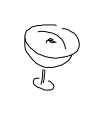

In [296]:
# get a sample drawing from the test set, and render it to .svg
stroke = train_set.random_sample()
draw_strokes(stroke)

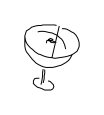

Input shape: (1, 251, 5)
Sequence length fed: 250
Expected max_seq_len: 250


In [297]:
#encode the sample stroke into latent vector 
z = encode(stroke)

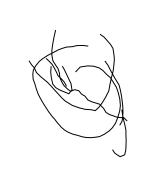

In [309]:
z_0 = decode(z, temperature=0.6) # convert z back to drawing at temperature x


In [225]:
#Create generated grid at various temperatures from 0.1 to 1.0

stroke_list = []
for i in range(10):
  stroke_list.append([decode(z_1, draw_mode=False, temperature=0.1*i+0.1), [0, i]])
stroke_grid = make_grid_svg(stroke_list)
draw_strokes(stroke_grid)

NameError: name 'z_1' is not defined

In [ ]:
# Get two random strokes from the test set
stroke_0 = test_set.random_sample()
stroke_1 = test_set.random_sample()

# Encode them into latent vectors
z0 = encode(stroke_0)
z1 = encode(stroke_1)

# Interpolate between them
N = 10
z_list = [slerp(z0, z1, t) for t in np.linspace(0, 1, N)]

# Decode interpolated latent vectors into stroke sequences
interpolations = [decode(z, temperature=1) for z in z_list]

# stroke_grid = make_grid_svg(reconstructions)
# draw_strokes(stroke_grid)

# Visualize the sequence one by one (X grid)
for i, s in enumerate(interpolations):
    print(f"Rendering step {i}")
    draw_strokes(s)

In [ ]:
z_list = []
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z0, z1, t))


In [ ]:
stroke = test_set.random_sample()
z = encode(stroke)
z_2 = decode (z, temperature = 0.8)

In [ ]:
#interpolate between z1 and z1

z_list = [] # interpolate spherically between z0 and z1
N = 10
for t in np.linspace(0, 1, N):
  z_list.append(slerp(z_0, z_2, t))

# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
  reconstructions.append([decode(z_list[i], draw_mode=False, temperature = 0.8), [0, i]])

stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)

In [ ]:
# Parameters
N_rows = 10     # number of interpolation steps (z vectors)
N_cols = 10     # number of temperatures per row
temperatures = np.linspace(0.1, 1.0, N_cols)

# Interpolate between z_1 and z_2
z_grid = [slerp(z0, z1, t) for t in np.linspace(0, 1, N_rows)]

# Generate the strokes grid
stroke_grid_data = []

for row_idx, z in enumerate(z_grid):
    for col_idx, temp in enumerate(temperatures):
        sketch = decode(z, draw_mode=False, temperature=temp)
        stroke_grid_data.append([sketch, [col_idx, row_idx]])

# Render as grid
stroke_grid = make_grid_svg(stroke_grid_data)
draw_strokes(stroke_grid)


In [ ]:
stroke = stroke3
incomplete = stroke[:19]
draw_strokes (incomplete)


In [ ]:
def decode_from_partial(partial_stroke, temperature=0.4, max_len=134):
    # Convert input stroke to big_strokes format
    stroke_big = [to_big_strokes(partial_stroke, max_len=134)]
    seq_len = [len(partial_stroke)]

    # Encode partial stroke into final decoder state
    final_state = sess.run(eval_model.final_state, feed_dict={
        eval_model.input_data: stroke_big,
        eval_model.sequence_lengths: seq_len
    })

    # Start token for generation
    input_token = np.array([[[0, 0, 1, 0, 0]]])  # (batch=1, len=1, dim=5)

    state = final_state
    generated = []

    for i in range(max_len):
        feed = {
            sample_model.input_data: input_token,
            sample_model.initial_state: state
        }
        output, state = sess.run(
            [sample_model.output, sample_model.final_state], feed_dict=feed
        )

        # Sample next point from GMM
        next_token = sample_next_point(output[0], temperature=temperature)

        generated.append(next_token)

        input_token = np.expand_dims([next_token], 0)  # shape: (1, 1, 5)

        # Optionally stop early if EOS token (third dim == 1)
        if next_token[2] == 1:
            break

    # Convert to numpy and return
    return np.array(generated)

In [ ]:
from magenta.models.sketch_rnn.utils import to_big_strokes

# Step 1: Convert incomplete to big strokes with correct padding
incomplete_big = to_big_strokes(incomplete, max_len=134)  # make sure this is 134
incomplete_big = np.expand_dims(incomplete_big, 0)  # shape: (1, 134, 5)

# Step 2: Set correct sequence length (only the valid portion)
seq_len = [len(incomplete)]  # NOT 134! Just the actual number of valid steps
print("input shape:", incomplete_big.shape)
print("seq_len:", seq_len)
print("expected input shape:", eval_model.input_data.shape)


# Step 3: Run the encoder or final decoder state
final_state = sess.run(
    eval_model.final_state,
    feed_dict={
        eval_model.input_data: incomplete_big,
        eval_model.sequence_lengths: seq_len
    }
)


In [ ]:
completed = decode_from_partial(incomplete, temperature=0.4)

In [ ]:
#load the Flamingo Model
#Unconditional (Decoder-Only) Generation

model_dir = '/kaggle/working/sketch_rnn_log'
[hps_model, eval_hps_model, sample_hps_model] = load_model_compatible(model_dir)


In [ ]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

In [ ]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
  reconstructions.append([decode(temperature=0.5, draw_mode=False), [0, i]])
     

In [ ]:
stroke_grid = make_grid_svg(reconstructions)
draw_strokes(stroke_grid)